e - энергетический пул = 2 * ATP + ADP + CrP

-- коэффициенты кубического уравнения относительно креатинфосфата

In [1]:
import numpy as np
import cmath

In [2]:
def coefficients(e, c0, p0, Ka, Kc):
    d = c0**2 * e * Ka
    c = -c0**2 * Ka + c0 * e * (-2 * Ka + Kc) - c0 * Kc * p0
    b = -c0 * (-2 * Ka + Kc) + e * (Ka + (-1 + Kc) * Kc) - Kc * (-1 + 2 * Kc) * p0
    a = -Ka - (-1 + Kc) * Kc
    return(np.array([a, b, c, d]))

In [3]:
coefficients(1, 1, 1, 1, 1)

array([-1,  1, -3,  1])

-- решаем кубическое уравнение $a * x^3 + b * x^2 + c * x + d = 0$


-- ищем только вещественный корень

In [4]:
# def  my_cubic_solve(a, b, c, d):
#     p = (3 * a * c - b**2) / (3 * a**2)
#     q = (2 * b**3 - 9 * a * b * c + 27 * a**2 * d) / (27 * a**3)
#     theta = complex((p /  3)^3 + (q / 2)^2)
#     alpha = complex((-q / 2 + theta^(1 / 2))^(1 / 3))
#     #beta = (-q / 2 - theta^(1 / 2))^(1 / 3)
#     beta = complex(-p / (3 * alpha))
#     result = complex(alpha + beta - b / (3 * a))
#     r, i = complex.get( result )
#     if math.abs(i) > 1e-6 then
#         print(string.format("my_cubic_solve(): imaginary part of root is too big, %e, should not happen", i))
#         return nil
#     else
#         return r

In [5]:
def  my_cubic_solve(array):
    roots = np.roots(array)
    real_roots = []
    for i in roots:
        if (i.imag == 0):
            real_roots.append(i.real)
    return (np.array(real_roots))

In [6]:
float(my_cubic_solve([1, 1, 1, 1]))

-1.0000000000000009

-- вычисляем концентрации АТФ, АДФ, АМФ и креатина 
-- из концентрации креатинфосфата, пула креатина, пула аденилатов
-- и констант равновесия аденилаткиназы и креатинкиназы

In [7]:
def tdmc(cp, c0, p0, Ka, Kc):
    c = c0  -  cp
    t = (cp**2  *  Kc**2  *  p0) / (c0**2 * Ka + c0 * cp * ( -2 * Ka + Kc) + cp**2 * (Ka + ( -1 + Kc) * Kc))
    d = ((c0 - cp) * cp * Kc * p0) / (c0**2 * Ka + c0 * cp * ( -2 * Ka + Kc) + cp**2 * (Ka + ( -1 + Kc) * Kc))
    m = ((c0 - cp)**2 * Ka * p0) / (c0**2 * Ka + c0 * cp * ( -2 * Ka + Kc) + cp**2 * (Ka + ( -1 + Kc) * Kc))
    return(t, d, m, c)

-- вычисляем концентрации креатина и креатинфосфата
-- по заданным концентрациям атф, адф, пулу креатина 
-- и константе креатинкиназного равновесия k = cr t / crp d

In [8]:
def equilibr_ck(k, c0, t, d):
    crp = c0 * t / (d * k + t)
    cr = c0 - crp
    return (cr, crp)

-- вычисляем концентрации аденилатов из пула аденилатов и 
-- энергетического пула
-- p - пул аденилатов, z = 2*atp + adp - энергетический пул

In [9]:
def tdm(p, z):
    atp = ( 3*z + p - (p*p + 6*p*z - 3*z*z)**0.5 ) / 6
    adp = z - 2*atp
    amp = p - z + atp
    return(atp, adp, amp)

In [10]:
def u_atpase(a, atp):
    return (a * atp)

def u_hk(a, atp, g6p):
	return (a * (atp/1) / (1 + atp/1 + g6p/0.0055))

def u_pgi(a, g6p, f6p):
	k1, k2, k3 = 3, 0.3, 0.2
	return (a * (g6p-f6p*k1)/k2/(1+g6p/k2+f6p/k3))

def u_pfk(a, atp, amp, f6p):
	az = (1+atp/0.195)/(1+amp/0.01)/(1+f6p/3.7e-4)
	zn = 1 + 1e8 * az**4
	ch = a * f6p / (f6p+0.1) * atp/(atp+2) * (1/(1+amp/0.01)+2*amp/(amp+0.01))
	return (1.1 * ch/zn)

def u_ald(a, fdp, dap, gap):
	k1, k2, k3 = 2e-4, 1.2e-5, 1e-2
	k4, k5, k6, k7 = 3.2e-2, 2.1e-3, 2, 6.5e-2
	x = fdp/k1 - dap*gap/k2
	y = 1 + fdp/k3 + dap/k4 + gap/k5 + fdp*dap/k3/k4 + dap*dap/k4/k6 + dap*gap/k4/k7
	return (a * x / y)
	# Aald_eff = Aald * k3 * k4 / (k1 * (DAP + k4))

def u_tpi(a, dap, gap):
	k1, k2, k3 = 8.2e-1, 0.45, 4.3e-1
	return (a*(dap-gap/k2)/k1/(1+dap/k1+gap/k3))

def u_gapd(a, gap, nad, pi, dpg13, nadh):
	k1, k2, k3 = 0.13, 0.13, 3.4
	k4, k5, k6 = 0.136, 1.25e-2, 2e-3
	tt1 = a * (gap*nad*pi - dpg13*nadh/k4)/k1/k2/k3
	tt2 = (1+pi/k3)*(1+gap/k1+dpg13/k5)*(1+nad/k2+nadh/k6)
	return (tt1/tt2)
	# Эффективная активность GAPD при данных NADH, NAD, PI в сторону образования 1,3ДФГ
	# Agapd_eff = (Agapd * k6 * NAD * PI) / (k6 * NAD + k2 * (k6 + NADH)) / (k3 + PI)

def u_pgk(a, dpg13, adp, pg3, atp):
	ch1 = a * (dpg13*adp - pg3*atp/380)/2.2E-3/0.14
	aa = (0.3 + adp + 0.3*atp/0.27) / 0.14
	ab = (0.4 + atp + adp*0.4/0.14) / 0.27
	zn1 = (1 + atp/0.27 + adp/0.14 + aa*dpg13/2.2E-3 + ab*pg3/1.4)
	return (ch1 / zn1)

def u_pgm(a, pg3, pg2):
	k1, k2, k3 = 0.27, 0.24, 2e-2
	return (a * (pg3 - pg2/k2) / k1 / (1 + pg3/k1 + pg2/k3))

def u_eno(a, pg2, pep):
	# Старый вариант из статьи Эрлих 1985. ЕНО здесь была практически необратимая
	# k1, k2, k3 = 5.6e-2, 6.7, 2e-3
	k1, k2, k3 = 28e-3, 5, 50e-3 # обновил параметры из литературы
	return (a * (pg2 - pep/k2) / k1 / (1 + pg2/k1 + pep/k3))

def u_pk(a, pep, adp, atp):
	k2 = 0.415
	ch = a * pep*adp/0.05/k2
	zn = 1 + pep/0.05 + adp/k2 + atp/0.35 + pep*adp/0.05/k2
	return (ch / zn)

def u_ld(a, pyr, nadh, lac, nad):
	k1, k2, k3 = 2.2e-2, 7e-3, 426
	k4, k5, k6, k7 = 1.4e-1, 380, 0.1, 170
	temp1 = (pyr*nadh - lac*nad/k3)/k1/k2
	temp2 = k7*nad + k6*lac + nad*lac + k7/k1*pyr*nad
	temp3 = 1 + pyr/k1 + (nadh*k4 + pyr*nadh + k4/k5*lac*nadh)/k1/k2 + temp2/k5/k6
	return (a * temp1/temp3)

-- Ферменты распада гликогена

In [11]:
def u_gp_a(a, pi, g1p):
	kp, kg, keq = 4, 2.7, 1/3
	# local keq = 1/12
	return (a * kg * (pi - g1p / keq) / (kg * kp + kg * pi + kp * g1p))


def u_gp_b(a, pi, g1p, amp):
	
	keq = 1/3 
	
	# local kp = 4 * (amp + 0.1) / 1.1 / amp
	# local kg = 2.7 * (amp + 0.1) / 2 / amp
	# local af = a * amp / (amp + 0.02)
	# return af * (pi * keq - g1p) / (kp * g1p + kg * pi + kp * kg)
	
	# local a, b = 7.2, 1.26
	# local c, d = 0.203, 0.7
	# local e, f = 22.7, 0.0139
	# local kp = a / amp + b
	# local kg = c / amp + d
	# local ar = e * amp / (amp + f)
	# local arn = ar / e
	# return a * arn * kp * (keq * pi - g1p) / (kp * g1p + kg * pi + kp * kg) 

	kg = 0.172 / amp + 1.11
	ar = amp / (amp + 0.0104)
	return (ar / kg * ( keq * pi - g1p ))



def u_pgcm(a, g1p, g6p):
	k1, k6, keq = 8.5e-3, 50e-3, 17
	return (a * k6 * (g1p - g6p / keq) / (k1 * k6 + k6 * g1p + k1 * g6p))

def u_gp_a_palm(a, pi, g1p, g6p, amp):
	n = 2
	krpi = 2.08
	krg1p = 0.67
	kramp = 3.4e-3
	krg6p = 7.4
	lu = 5.9
	kupi = 4.3
	kug1p = 82
	kug6p = 0.56
  
	v1 = a*n*pi/krpi*(1 + pi/krpi + g1p/krg1p)**(n - 1)
	v2 = (1 + pi/krpi + g1p/krg1p)**n + lu*(1 + pi/kupi + g1p/kug1p)**n*(1 + g6p/kug6p)**n/(1 + amp/kramp + g6p/krg6p)**n

	return (a * v1 / v2)

-- Вариант 0: исходная модель гликолиза в эритроците человека, 
-- без 2,3-ДФГ шунта. Используем для построения характеристики 
-- гликолиза, то есть АТФ - параметр.

Начальные условия

In [12]:
k_ak = 1
a_pgi = 360
a_ald = 76
a_gapd =690
a_pgm = 1100
a_pk = 120
a_ld = 550
a_tpi = 19522
a_pgk = 2115
a_eno = 204

# Glycolytic intermediates quantities in 1L of erythrocytes, mM
g6p = 73.1e-03
f6p = 23.9e-03
fdp = 7.49e-03
dap = 31.79e-03
gap = 14.1e-03
dpg13 = 0.734e-03
pg3 = 45.3e-03
pg2 = 10.7e-03
pep = 9.82e-03
pyr, lac = 70e-3, 1.2
po4 = 1
nad_0, nadh = 50e-3, 2e-03

a_gp_a, a_gp_b = 5000, 5000
a_pgcm = 4200
g1p = 0.05
ACT = 100

k_ck, c_0 = 5, 30
atp, amp = 5, 0.02
# активности ГК и ФФК для мышцы, по данным Витвицкого
# усреднённые по человеку и кролику
a_hk = 60
a_pfk = 4000
v_0 = 10
#v_0 = 500

ACT_gapd, ACT_pgk, ACT_pgm, ACT_eno, ACT_pk, ACT_ld = 1, 1, 1, 1, 1, 1

In [13]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [14]:
nad = nad_0 - nadh
adp = ( atp * amp / k_ak )**0.5
p_0 = atp + adp + amp

a_atpase = v_0 / u_atpase(1, atp) 

cr, crp = equilibr_ck(k_ck, c_0, atp, adp) 
ep = 2 * atp + adp + crp
po4_0 = g1p + g6p + f6p + 2*fdp + dap + gap + 2*dpg13 + pg3 + pg2 + pep + ep + po4 

In [15]:
a_atpase

2.0

ДУ

In [16]:
y0 = [f6p, fdp, dap, gap, dpg13, pg3, pg2, pep, nadh, ep, g1p, g6p]


def right_part(y, t):
    dy = np.zeros(len(y))
    
    f6p_ = y[0]
    fdp_ = y[1]
    dap_ = y[2]
    gap_ = y[3]
    dpg13_ = y[4]
    pg3_ = y[5]
    pg2_ = y[6]
    pep_ = y[7]
    nadh_ = y[8]
    #ep_ = y[9]
    g6p_ = y[9]
    g1p_ = y[10]

    
    
    dy[0] = u_pgi(a_pgi, g6p_, f6p_) - u_pfk(a_pfk, atp, amp, f6p_)
    dy[1] = u_pfk(a_pfk, atp, amp, f6p_) - u_ald(a_ald, fdp_, dap_, gap_)
    dy[2] = u_ald(a_ald, fdp_, dap_, gap_) - u_tpi(a_tpi, dap_, gap_)
    dy[3] = u_tpi(a_tpi, dap_, gap_) + u_ald(a_ald, fdp_, dap_, gap_) - u_gapd(a_gapd * ACT, gap_, nad, po4, dpg13_, nadh_)
    dy[4] = u_gapd(a_gapd * ACT, gap_, nad, po4, dpg13_, nadh_) - u_pgk(a_pgk * ACT, dpg13_, adp, pg3_, atp)
    dy[5] = u_pgk(a_pgk * ACT, dpg13_, adp, pg3_, atp) - u_pgm(a_pgm * ACT, pg3_, pg2_)
    dy[6] = u_pgm(a_pgm * ACT, pg3_, pg2_) - u_eno(a_eno * ACT, pg2_, pep_)
    dy[7] = u_eno(a_eno * ACT, pg2_, pep_) - u_pk(a_pk * ACT, pep_, adp, atp)
    dy[8] = u_gapd(a_gapd * ACT, gap_, nad, po4, dpg13_, nadh_) - u_ld(a_ld * ACT, pyr, nadh_, lac, nad)
    #dy[9] = -u_hk(a_hk, atp, g6p_) - u_pfk(a_pfk, atp, amp, f6p_)+ u_pgk(a_pgk * ACT, dpg13_, adp, pg3_, atp) + u_pk(a_pk * ACT, pep_, adp, atp) - u_atpase(a_atpase, atp)
    dy[9] = u_hk(a_hk, atp, g6p_) - u_pgi(a_pgi, g6p_, f6p_) + u_pgcm(a_pgcm, g1p_, g6p_)
    dy[10] = u_gp_a(a_gp_a, po4, g1p_) - u_pgcm(a_pgcm, g1p_, g6p_)
    
    return(dy)

In [17]:
t = np.linspace(0,10,1000)

In [18]:
# atp_pool = np.linspace(0.01,atp,200)

In [19]:
from sympy import symbols, Eq, solve

In [20]:
ep_pool = np.linspace(0.001, 2 * p_0 + c_0, 500)

In [21]:
res = []
atp_p = []
adp_p = []
amp_p = []
po4_p = []
for ep in ep_pool:
    nad = nad_0 - nadh
    po4_up = g1p + g6p + f6p + 2*fdp + dap + gap
    po4_down = 2*dpg13 + pg3 + pg2 + pep
    po4 = po4_0 - ( po4_up + po4_down + ep )
    crp = float(my_cubic_solve(coefficients(ep, c_0, p_0, k_ak, k_ck)))
    atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
    atp_p.append(atp)
    adp_p.append(adp)
    amp_p.append(amp)
    po4_p.append(po4)
    res.append(odeint(right_part,y0,t))

/Users/svetlanasudarkina/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [22]:
# res = odeint(right_part,y0,t)

Graphics

In [23]:
f6p = np.array(res)[:, :,0]
fdp = np.array(res)[:, :,1]
dap = np.array(res)[:, :,2]
gap = np.array(res)[:, :,3]
dpg13 = np.array(res)[:, :,4]
pg3 = np.array(res)[:, :,5]
pg2 = np.array(res)[:, :,6]
pep = np.array(res)[:, :,7]
nadh = np.array(res)[:, :,8]
g6p = np.array(res)[:, :,9]
g1p = np.array(res)[:, :,10]

In [24]:
# f6p = np.array(res)[:,:,0]
# fdp = np.array(res)[:,:,1]
# dap = np.array(res)[:,:,2]
# gap = np.array(res)[:,:,3]
# dpg13 = np.array(res)[:,:,4]
# pg3 = np.array(res)[:,:,5]
# pg2 = np.array(res)[:,:,6]
# pep = np.array(res)[:,:,7]
# nadh = np.array(res)[:,:,8]
# ep = np.array(res)[:,:,9]
# g6p = np.array(res)[:,:,10]
# g1p = np.array(res)[:,:,11]

In [25]:
#g6p[atp,t]

In [26]:
len(g6p[1, :])

1000

v_hk= u_hk(a_hk, atp, g6p)
v_pgi= u_pgi(a_pgi, g6p, f6p)
v_pfk= u_pfk(a_pfk, atp, amp, f6p)
v_ald = u_ald(a_ald, fdp, dap, gap)
v_tpi = u_tpi(a_tpi, dap, gap)

v_atpase = u_atpase(a_atpase, atp)

v_gapd = u_gapd(a_gapd * ACT, gap, nad, po4, dpg13, nadh)
v_pgk = u_pgk(a_pgk * ACT, dpg13, adp, pg3, atp)
v_pgm = u_pgm(a_pgm * ACT, pg3, pg2)
v_eno = u_eno(a_eno * ACT, pg2, pep)
v_pk = u_pk(a_pk * ACT, pep, adp, atp)
v_ld = u_ld(a_ld * ACT, pyr, nadh, lac, nad)

v_production = -v_hk - v_pfk + v_pgk + v_pk

v_gp_a = u_gp_a(a_gp_a, po4, g1p)
v_gp_b = u_gp_b(a_gp_b, po4, g1p, amp)
v_pgcm = u_pgcm(a_pgcm, g1p, g6p)

In [27]:
v_pfk_atp = []
v_hk_atp = []
v_pgk_atp = []
v_pk_atp = []
for ix, atp in enumerate(atp_p):
    v_pfk_atp.append(u_pfk(a_pfk, atp, amp_p[ix], f6p[ix,-1]))
    v_hk_atp.append(u_hk(a_hk, atp, g6p[ix,-1]))
    v_pgk_atp.append(u_pgk(a_pgk * ACT, dpg13[ix,-1], adp_p[ix], pg3[ix,-1], atp))
    v_pk_atp.append(u_pk(a_pk * ACT, pep[ix,-1], adp_p[ix], atp))

In [28]:
fdp[0, -1]

4.795375793462311e-10

In [29]:
atp_p[406]

4.999073118889689

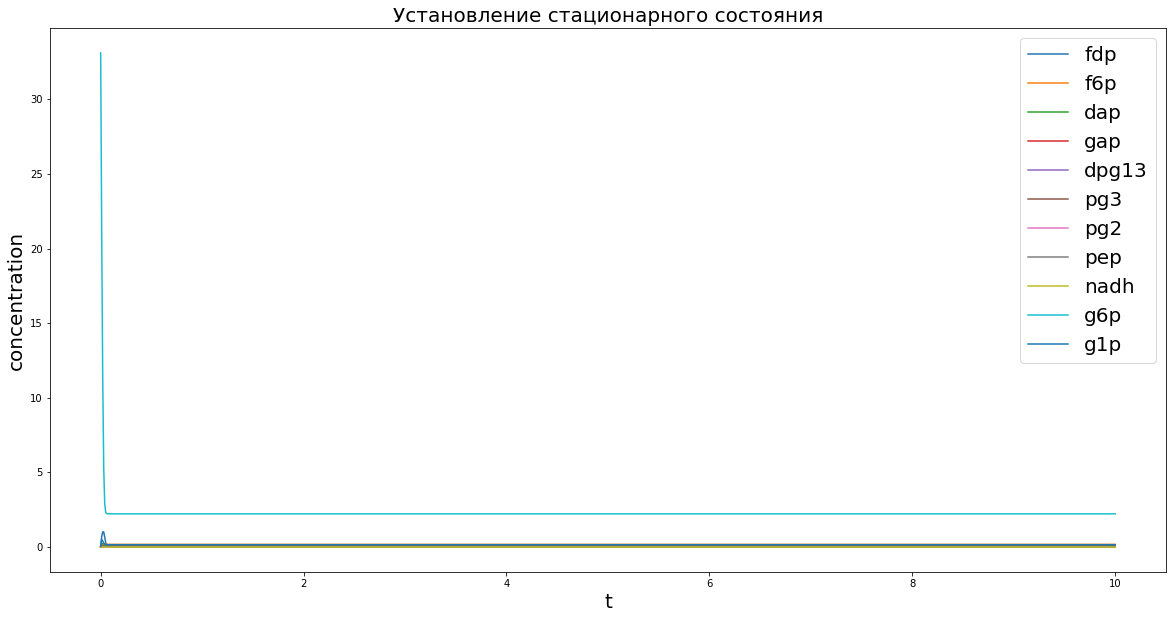

In [30]:
plt.figure(figsize = (20, 10))
plt.plot(t,fdp[410,:])
plt.plot(t,f6p[410, :])
plt.plot(t,dap[410, :])
plt.plot(t,gap[410, :])
plt.plot(t,dpg13[410, :])
plt.plot(t,pg3[410, :])
plt.plot(t,pg2[410, :])
plt.plot(t,pep[410, :])
plt.plot(t,nadh[410, :])
plt.plot(t,g6p [410, :])
plt.plot(t,g1p [410, :])
plt.legend(['fdp', 'f6p', 'dap', 'gap', 'dpg13', 'pg3', 'pg2', 'pep', 'nadh', 'g6p', 'g1p'], fontsize = 20)
plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('t', size = 20)
plt.ylabel('concentration', size = 20)
plt.show()

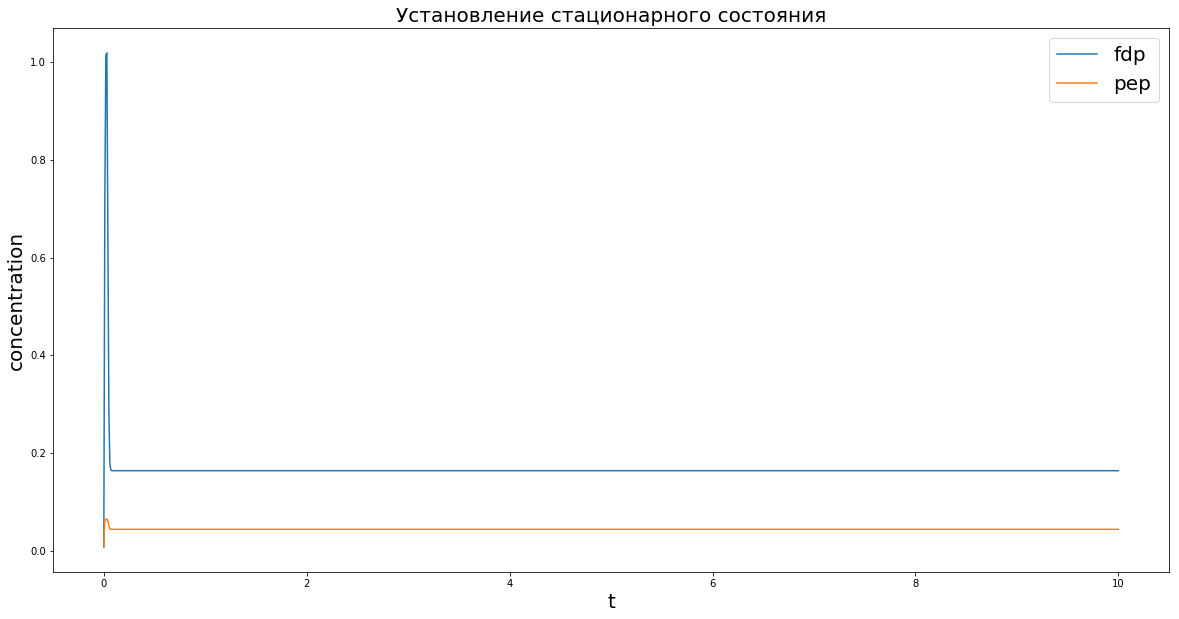

In [31]:
plt.figure(figsize = (20, 10))
plt.plot(t,fdp[410,:])
plt.plot(t,pep[410, :])
plt.legend(['fdp', 'pep'], fontsize = 20)
plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('t', size = 20)
plt.ylabel('concentration', size = 20)
plt.show()

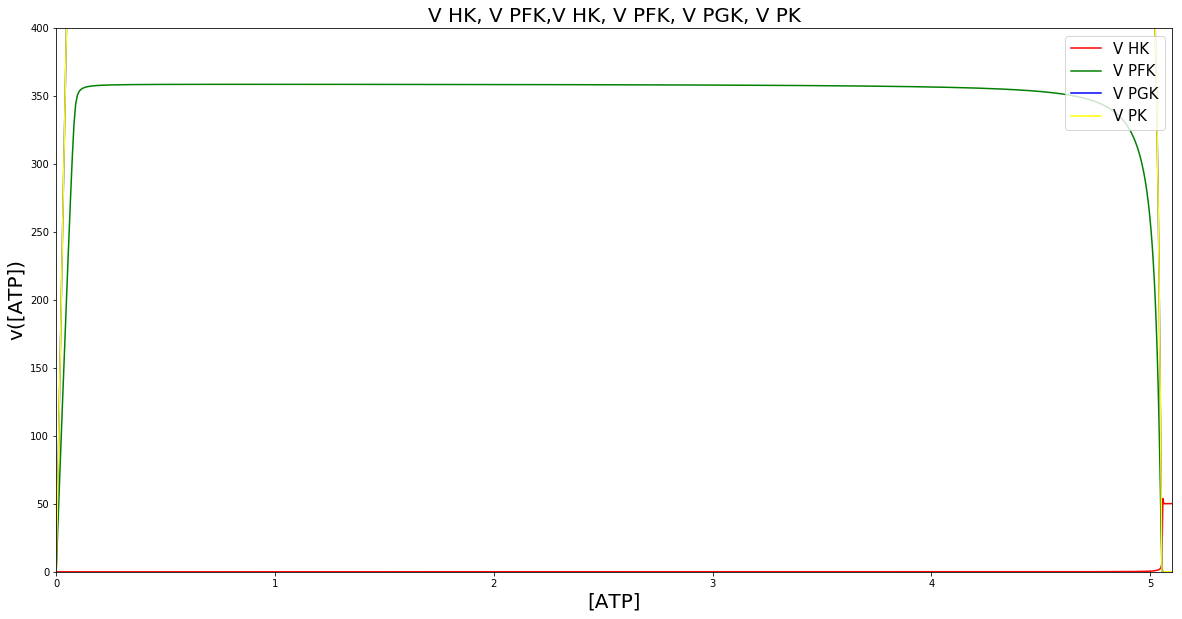

In [32]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,np.array(v_hk_atp), color = 'red')
plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.plot(atp_p,np.array(v_pgk_atp), color = 'blue')
plt.plot(atp_p,np.array(v_pk_atp), color = 'yellow')

plt.title('V HK, V PFK,V HK, V PFK, V PGK, V PK', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
plt.legend(['V HK', 'V PFK', 'V PGK', 'V PK'], fontsize = 15, loc="upper right")
plt.xlim(0, 5.1)
plt.ylim(0, 1000)
plt.show()

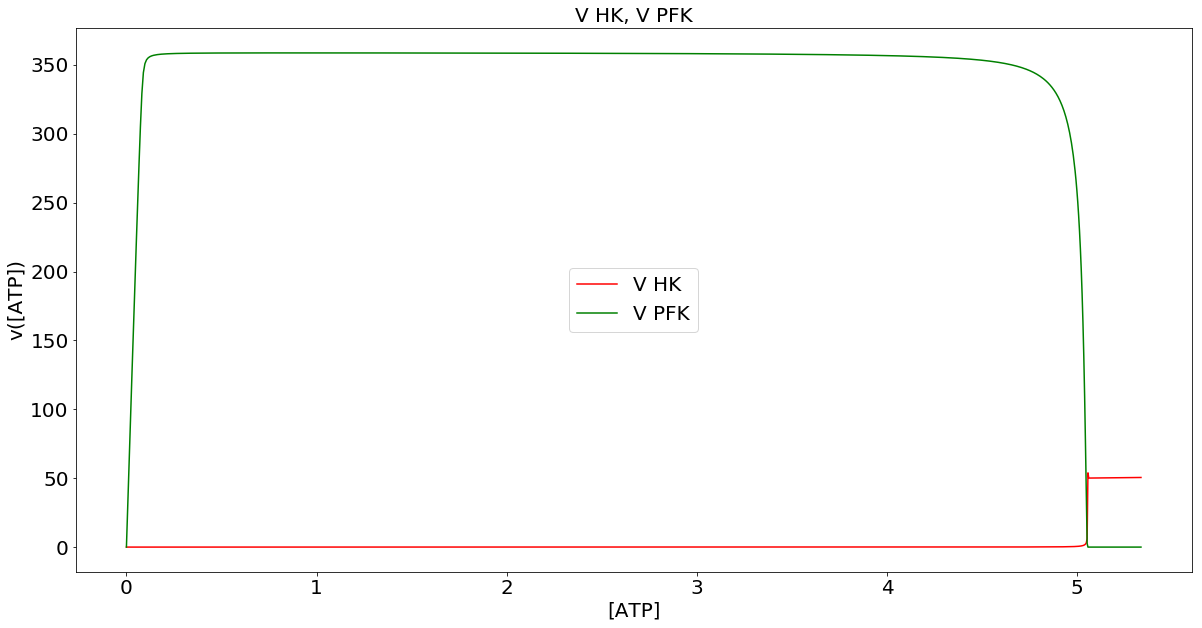

In [33]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,np.array(v_hk_atp), color = 'red')
plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('V HK, V PFK', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
plt.legend(['V HK', 'V PFK'], fontsize = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [34]:
v_production_atp = []
for ix, atp in enumerate(atp_p):
    v_production_atp.append(-v_hk_atp[ix] - v_pfk_atp[ix] + v_pgk_atp[ix] + v_pk_atp[ix])

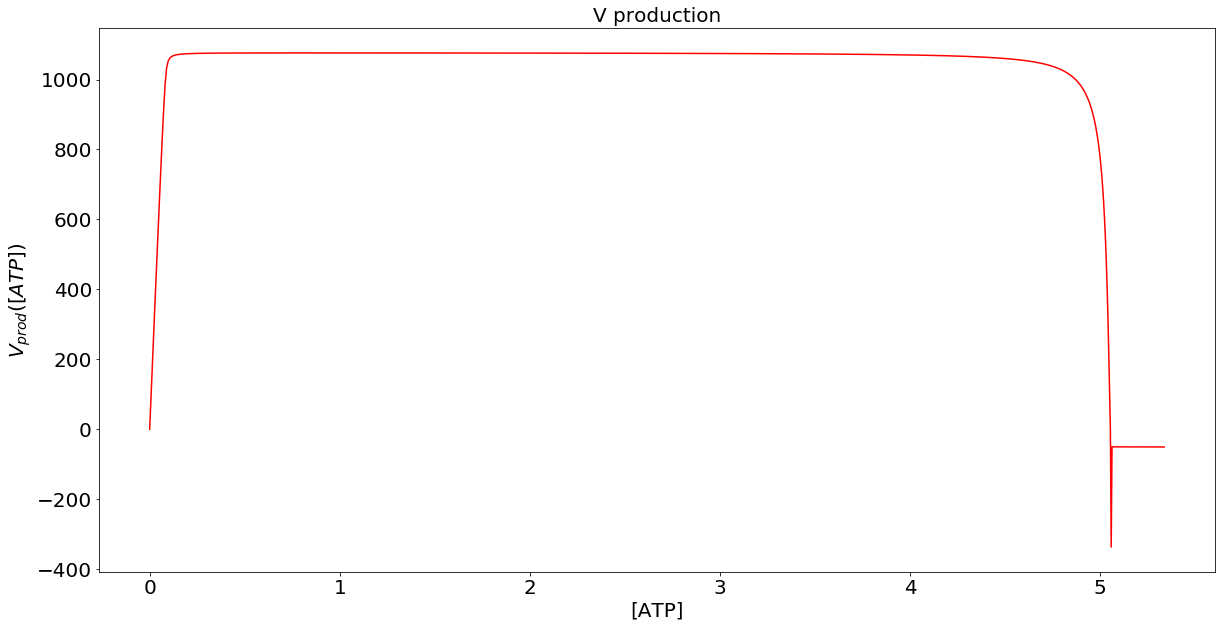

In [35]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,np.array(v_production_atp), color = 'red')
plt.title('V production', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('$V_{prod}([ATP])$', size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

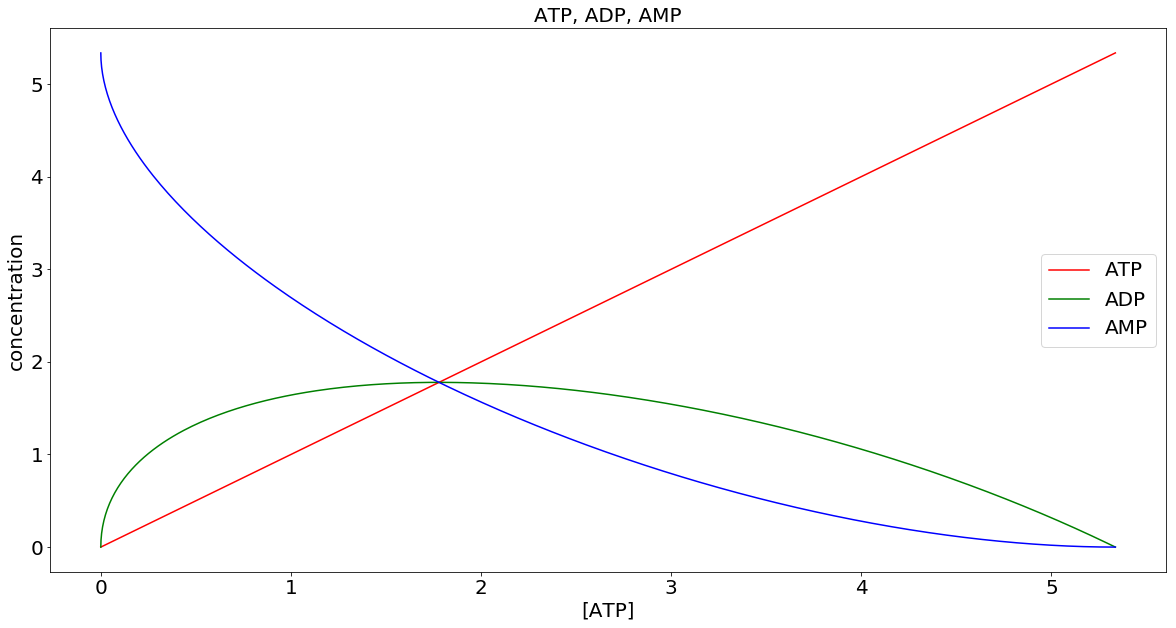

In [36]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,atp_p, color = 'red')
plt.plot(atp_p,adp_p, color = 'green')
plt.plot(atp_p,amp_p, color = 'blue')

plt.title('ATP, ADP, AMP' , size = 20)
plt.xlabel('[ATP]' , size = 20)
plt.ylabel('concentration' , size = 20)
plt.legend(['ATP', 'ADP', 'AMP'], fontsize = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

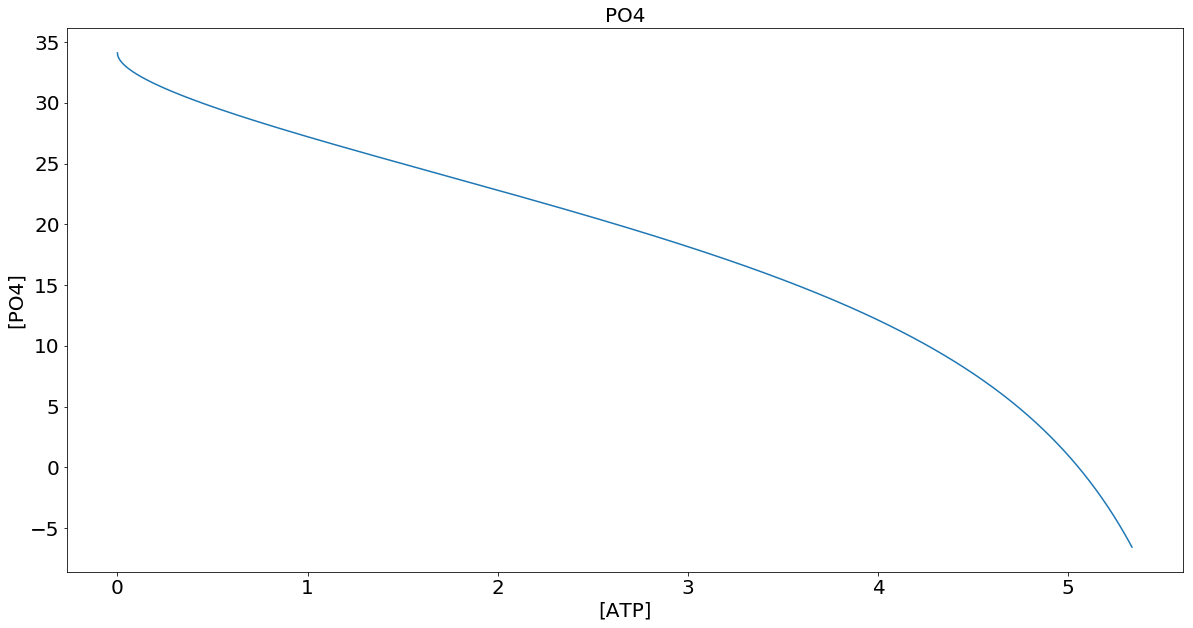

In [37]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,po4_p)

plt.title('PO4' , size = 20)
plt.xlabel('[ATP]' , size = 20)
plt.ylabel('[PO4]' , size = 20)

plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

Построим график зависимости $V_{HK}$ от концентрации АТФ при различных значениях активности GP

НУ

In [38]:
GP_act = [0, 10, 50, 100, 200, 1000, 5000]

In [39]:
k_ak = 1
a_pgi = 360
a_ald = 76
a_gapd =690
a_pgm = 1100
a_pk = 120
a_ld = 550
a_tpi = 19522
a_pgk = 2115
a_eno = 204

# Glycolytic intermediates quantities in 1L of erythrocytes, mM
g6p = 73.1e-03
f6p = 23.9e-03
fdp = 7.49e-03
dap = 31.79e-03
gap = 14.1e-03
dpg13 = 0.734e-03
pg3 = 45.3e-03
pg2 = 10.7e-03
pep = 9.82e-03
pyr, lac = 70e-3, 1.2
po4 = 1
nad_0, nadh = 50e-3, 2e-03

#a_gp_a = 5000
a_gp_b = 5000
a_pgcm = 4200
g1p = 0.05
ACT = 100

k_ck, c_0 = 5, 30
atp, amp = 5, 0.02
# активности ГК и ФФК для мышцы, по данным Витвицкого
# усреднённые по человеку и кролику
a_hk = 60
a_pfk = 4000
v_0 = 10
#v_0 = 500

ACT_gapd, ACT_pgk, ACT_pgm, ACT_eno, ACT_pk, ACT_ld = 1, 1, 1, 1, 1, 1

In [40]:
nad = nad_0 - nadh
adp = ( atp * amp / k_ak )**0.5
p_0 = atp + adp + amp

a_atpase = v_0 / u_atpase(1, atp) 

cr, crp = equilibr_ck(k_ck, c_0, atp, adp) 
ep = 2 * atp + adp + crp
po4_0 = g1p + g6p + f6p + 2*fdp + dap + gap + 2*dpg13 + pg3 + pg2 + pep + ep + po4 

In [41]:
res = [[] for _ in range(len(ep_pool))]
atp_p = []
adp_p = []
amp_p = []
for ix, ep in enumerate(ep_pool):
    nad = nad_0 - nadh
    po4_up = g1p + g6p + f6p + 2*fdp + dap + gap
    po4_down = 2*dpg13 + pg3 + pg2 + pep
    po4 = po4_0 - ( po4_up + po4_down + ep )
    crp = float(my_cubic_solve(coefficients(ep, c_0, p_0, k_ak, k_ck)))
    atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
    atp_p.append(atp)
    adp_p.append(adp)
    amp_p.append(amp)
    for a_gp_a in GP_act:
        res[ix].append(odeint(right_part,y0,t))

np.array(res)[atp, gpact, t,0]

In [42]:
len(np.array(res)[1, 1, 1,:])

12

In [43]:
f6p = np.array(res)[:, :, :,0]
fdp = np.array(res)[:, :, :,1]
dap = np.array(res)[:, :, :,2]
gap = np.array(res)[:, :, :,3]
dpg13 = np.array(res)[:, :, :,4]
pg3 = np.array(res)[:, :, :,5]
pg2 = np.array(res)[:, :, :,6]
pep = np.array(res)[:, :, :,7]
nadh = np.array(res)[:, :, :,8]
g6p = np.array(res)[:, :, :,9]
g1p = np.array(res)[:, :, :,10]

g6p[ix, 6,-1]

In [44]:
v_hk_atp_gp = [[] for _ in range(len(atp_p))]
for ix, atp in enumerate(atp_p):
    for i, a_gp_a in enumerate(GP_act):
        v_hk_atp_gp[ix].append(u_hk(a_hk, atp, g6p[ix, i,-1]))

In [45]:
ep_pool[250]

20.377480727471784

In [46]:
atp_p[429]

5.099305912558306

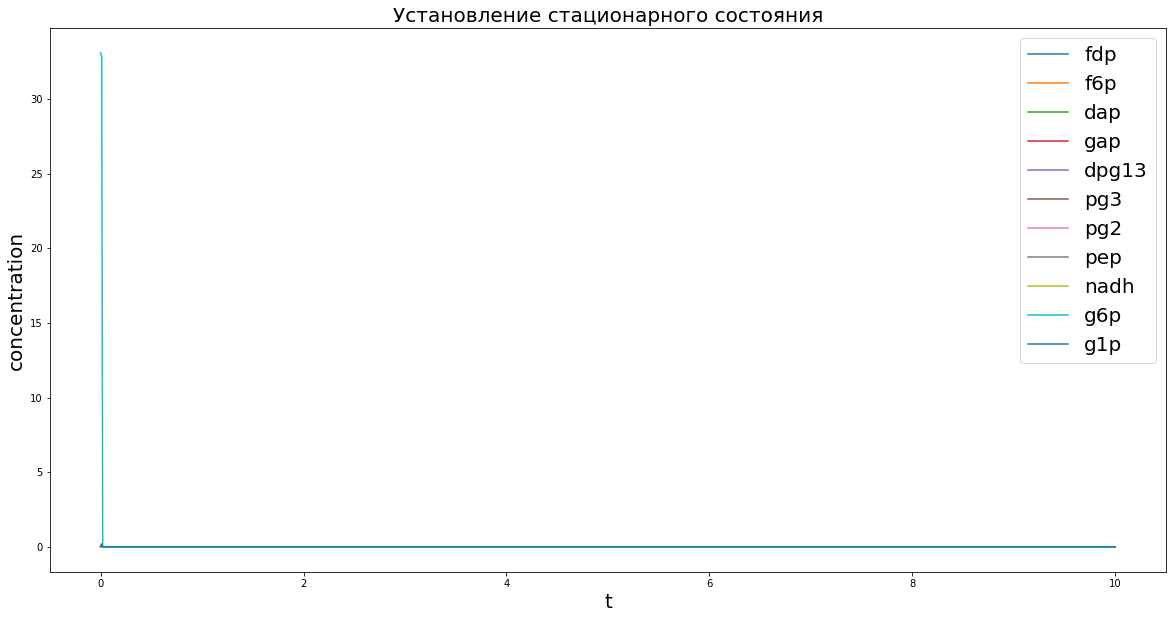

In [47]:
plt.figure(figsize = (20, 10))
plt.plot(t,fdp[429,5, :])
plt.plot(t,f6p[429,5,  :])
plt.plot(t,dap[429,5,  :])
plt.plot(t,gap[429,5,  :])
plt.plot(t,dpg13[429,5,  :])
plt.plot(t,pg3[429,5,  :])
plt.plot(t,pg2[429,5,  :])
plt.plot(t,pep[429,5,  :])
plt.plot(t,nadh[429,5,  :])
plt.plot(t,g6p [429,5,  :])
plt.plot(t,g1p [429,5,  :])
plt.legend(['fdp', 'f6p', 'dap', 'gap', 'dpg13', 'pg3', 'pg2', 'pep', 'nadh', 'g6p', 'g1p'], fontsize = 20)
plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('t', size = 20)
plt.ylabel('concentration', size = 20)
#plt.xlim(-0.05, 10.5)
#plt.ylim(0, 0.005)
plt.show()

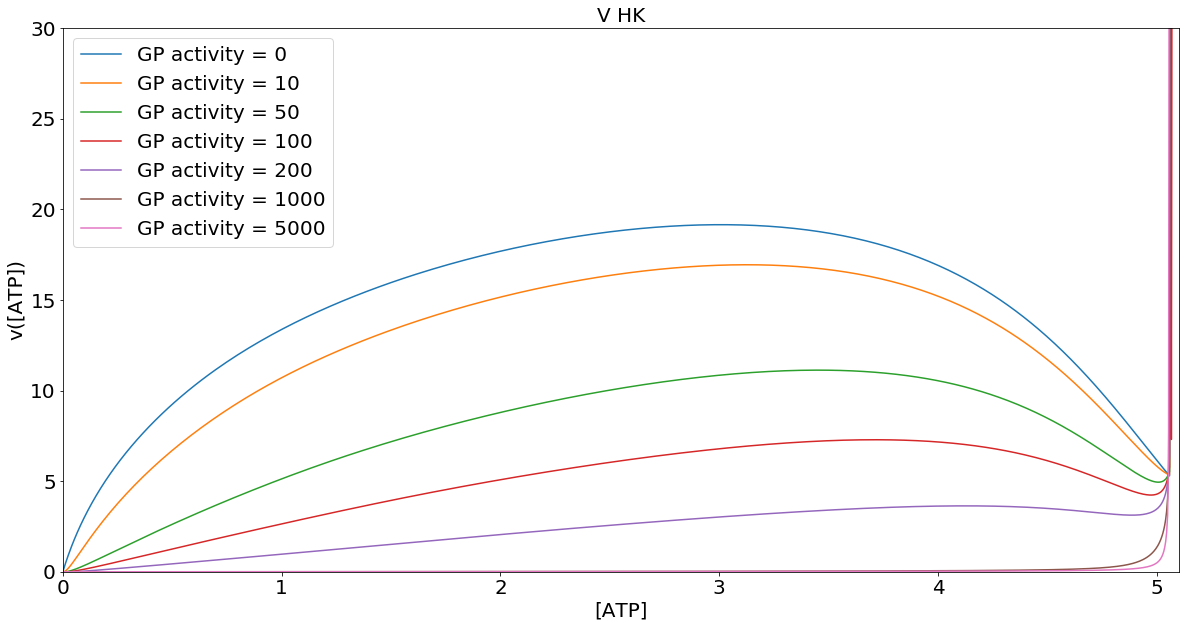

In [48]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,np.array(v_hk_atp_gp)[:, 0])
plt.plot(atp_p,np.array(v_hk_atp_gp)[:, 1])
plt.plot(atp_p,np.array(v_hk_atp_gp)[:, 2])
plt.plot(atp_p,np.array(v_hk_atp_gp)[:, 3])
plt.plot(atp_p,np.array(v_hk_atp_gp)[:, 4])
plt.plot(atp_p,np.array(v_hk_atp_gp)[:, 5])
plt.plot(atp_p,np.array(v_hk_atp_gp)[:, 6])
#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('V HK', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}', \
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}', \
            f'GP activity = {GP_act[6]}'], fontsize = 20)
plt.xlim(0, 5.1)
plt.ylim(0, 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [49]:
v_hk_atp_gp = [[] for _ in range(len(atp_p))]
v_pfk_atp_gp = [[] for _ in range(len(atp_p))]
v_pgk_atp_gp = [[] for _ in range(len(atp_p))]
v_pk_atp_gp = [[] for _ in range(len(atp_p))]
#v_production_atp_gp = [[] for _ in range(len(atp_p))]
for ix, atp in enumerate(atp_p):
    for i, a_gp_a in enumerate(GP_act):
        v_hk_atp_gp[ix].append(u_hk(a_hk, atp, g6p[ix, i,-1]))
        v_pfk_atp_gp[ix].append(u_pfk(a_pfk, atp, amp_p[ix], f6p[ix, i,-1]))
        v_pgk_atp_gp[ix].append(u_pgk(a_pgk * ACT, dpg13[ix, i,-1], adp_p[ix], pg3[ix, i,-1], atp))
        v_pk_atp_gp[ix].append(u_pk(a_pk * ACT, pep[ix, i,-1], adp_p[ix], atp))
        #v_production_atp_gp[ix].append(-np.array(v_hk_atp_gp)[ix, i] - np.array(v_pfk_atp_gp)[ix, i] + np.array(v_pgk_atp_gp)[ix, i] + np.array(v_pk_atp_gp)[ix, i])

In [50]:
-np.array(v_pk_atp_gp)[ix, i]

0.0

In [51]:
v_production_atp_gp = [[] for _ in range(len(atp_p))]
for ix, atp in enumerate(atp_p):
    for i, a_gp_a in enumerate(GP_act):
        v_production_atp_gp[ix].append(-np.array(v_hk_atp_gp)[ix, i] -np.array(v_pfk_atp_gp)[ix, i] + np.array(v_pgk_atp_gp)[ix, i] + np.array(v_pk_atp_gp)[ix, i])
        

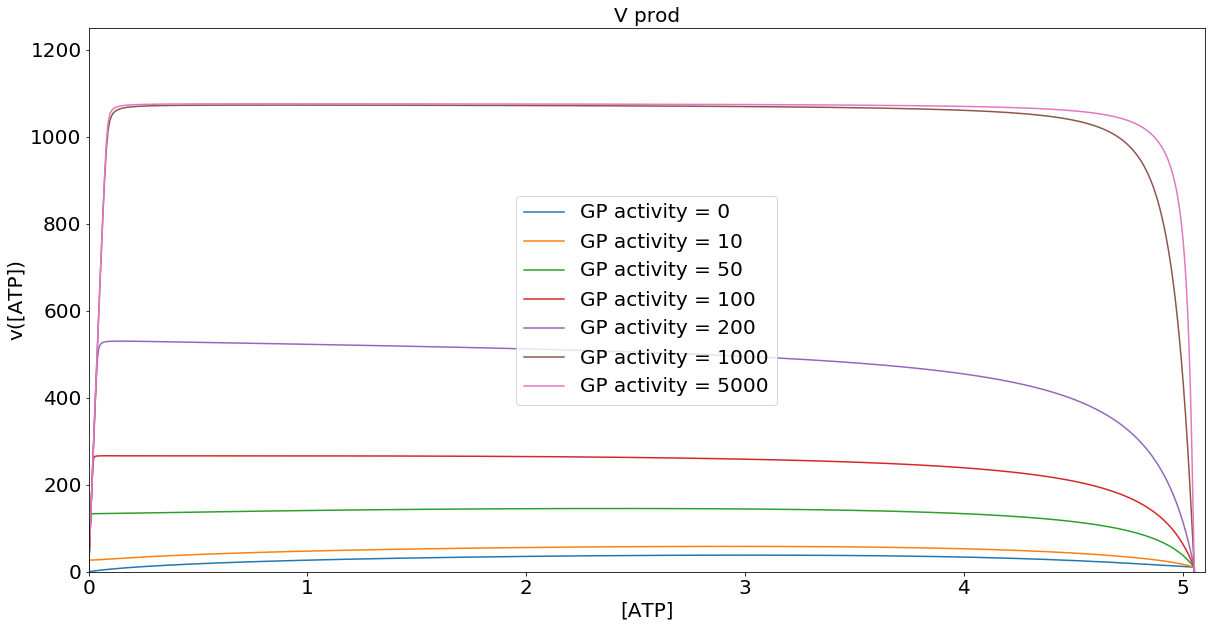

In [52]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,np.array(v_production_atp_gp)[:, 0])
plt.plot(atp_p,np.array(v_production_atp_gp)[:, 1])
plt.plot(atp_p,np.array(v_production_atp_gp)[:, 2])
plt.plot(atp_p,np.array(v_production_atp_gp)[:, 3])
plt.plot(atp_p,np.array(v_production_atp_gp)[:, 4])
plt.plot(atp_p,np.array(v_production_atp_gp)[:, 5])
plt.plot(atp_p,np.array(v_production_atp_gp)[:, 6])

plt.title('V prod', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}', \
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}', \
            f'GP activity = {GP_act[6]}'], fontsize = 20)
plt.xlim(0, 5.1)
plt.ylim(0, 1250)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [1]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,np.array(v_production_atp_gp)[:, 0])

plt.title('V prod', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
# plt.legend([f'GP activity = {GP_act[0]}',\
#             f'GP activity = {GP_act[1]}',\
#             f'GP activity = {GP_act[2]}', \
#             f'GP activity = {GP_act[3]}', \
#             f'GP activity = {GP_act[4]}',\
#             f'GP activity = {GP_act[5]}', \
#             f'GP activity = {GP_act[6]}'], fontsize = 20)
plt.xlim(0, 5.1)
plt.ylim(0, 1250)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

NameError: name 'plt' is not defined

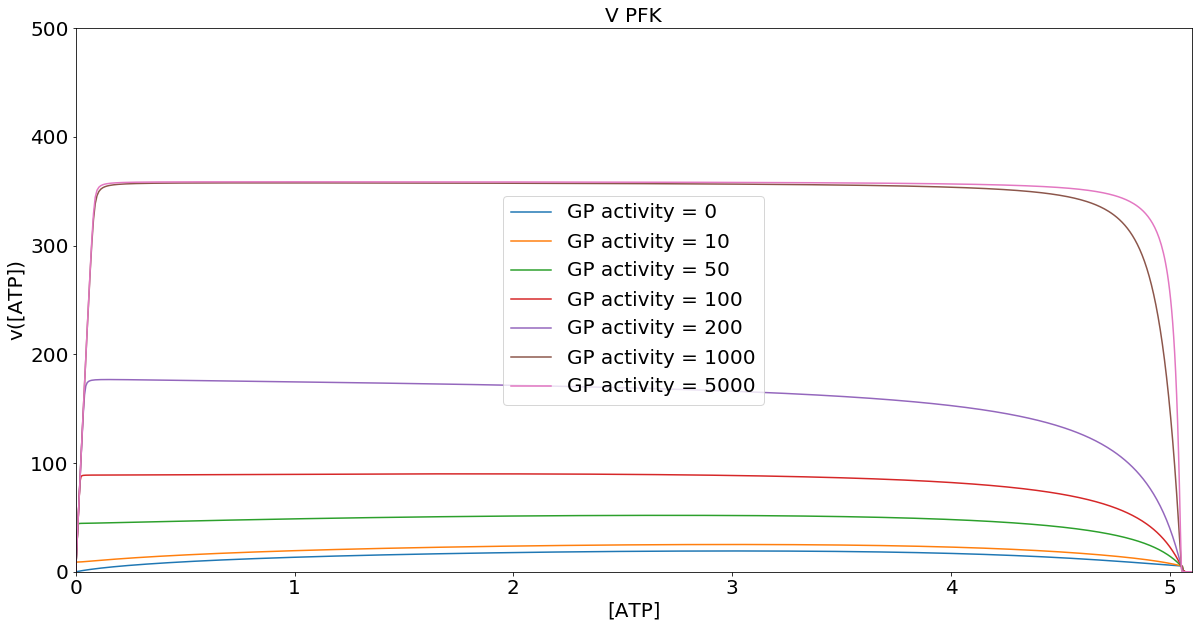

In [57]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,np.array(v_pfk_atp_gp)[:, 0])
plt.plot(atp_p,np.array(v_pfk_atp_gp)[:, 1])
plt.plot(atp_p,np.array(v_pfk_atp_gp)[:, 2])
plt.plot(atp_p,np.array(v_pfk_atp_gp)[:, 3])
plt.plot(atp_p,np.array(v_pfk_atp_gp)[:, 4])
plt.plot(atp_p,np.array(v_pfk_atp_gp)[:, 5])
plt.plot(atp_p,np.array(v_pfk_atp_gp)[:, 6])
#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('V PFK', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}', \
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}', \
            f'GP activity = {GP_act[6]}'], fontsize = 20)
plt.xlim(0, 5.1)
plt.ylim(0, 500)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

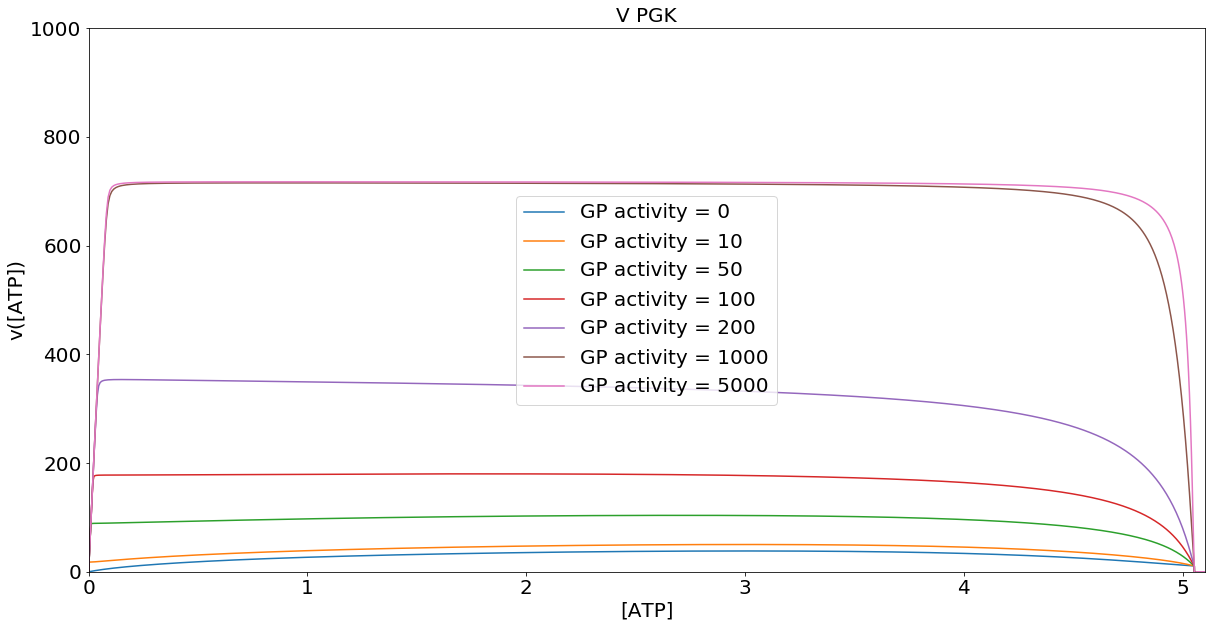

In [59]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,np.array(v_pgk_atp_gp)[:, 0])
plt.plot(atp_p,np.array(v_pgk_atp_gp)[:, 1])
plt.plot(atp_p,np.array(v_pgk_atp_gp)[:, 2])
plt.plot(atp_p,np.array(v_pgk_atp_gp)[:, 3])
plt.plot(atp_p,np.array(v_pgk_atp_gp)[:, 4])
plt.plot(atp_p,np.array(v_pgk_atp_gp)[:, 5])
plt.plot(atp_p,np.array(v_pgk_atp_gp)[:, 6])
#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('V PGK', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}', \
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}', \
            f'GP activity = {GP_act[6]}'], fontsize = 20)
plt.xlim(0, 5.1)
plt.ylim(0, 1000)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

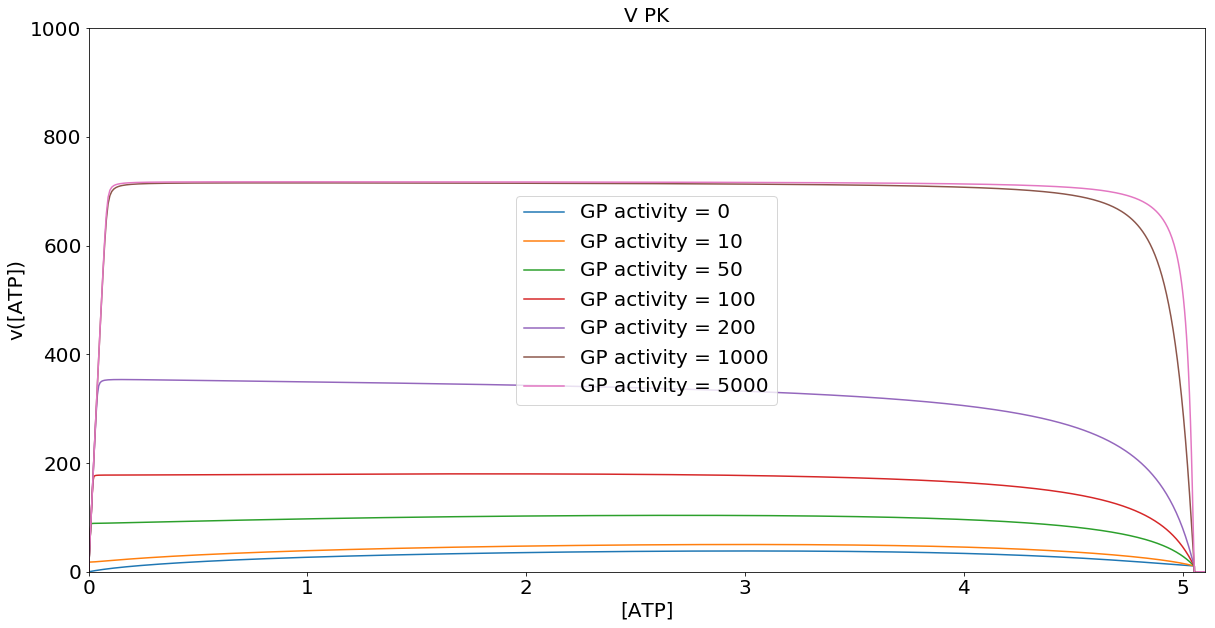

In [61]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,np.array(v_pk_atp_gp)[:, 0])
plt.plot(atp_p,np.array(v_pk_atp_gp)[:, 1])
plt.plot(atp_p,np.array(v_pk_atp_gp)[:, 2])
plt.plot(atp_p,np.array(v_pk_atp_gp)[:, 3])
plt.plot(atp_p,np.array(v_pk_atp_gp)[:, 4])
plt.plot(atp_p,np.array(v_pk_atp_gp)[:, 5])
plt.plot(atp_p,np.array(v_pk_atp_gp)[:, 6])
#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('V PK', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}', \
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}', \
            f'GP activity = {GP_act[6]}'], fontsize = 20)
plt.xlim(0, 5.1)
plt.ylim(0, 1000)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()